<a href="https://colab.research.google.com/github/minhbao1705/Keras-tutorial/blob/main/Chap3_Keras_functional_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The keras functional API is the way to go for defining complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.

This guide assumes that you are already familiar with Sequential model.

# **First example: a densely connected network**

The Sequential model is probably a better choice to implement such a network, but it helps to start with something really simple.

* A layer instance is callable (on a tensor) and it returns a tensor
* Input tensor(s) and output tensor(s) can then be used to define a Model
* Such a model can be trained just like Keras Sequential models.

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

# This returns a tensor
inputs = Input(shape=(784, ))

# a layer instance is callable on a tensor and returns a tensor
output_1 = Dense(64, activation='relu')(inputs)
output_2 = Dense(64, activation='relu')(output_1)
predictions = Dense(10, activation='softmax')(output_2)

# This creates a model that includes
# The input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crassentropy',
              metrics=['accuracy'])

# start training
model.fit(data, labels)

# **All models are callable, just like layers**
With the functional API, it is easy to reuse trained models: you can treat any model as if it were a layer, by calling it on a tensor. Note that by calling a model you aren't just reusing the architecture of the model, you are also reusing its weights.

In [ ]:
x = Input(shape=(784, ))
# This works and returns the 10-way softmax we defined above
y=model(x)

This can allow, for instance to quickly create models that can process sequences of inputs. You could turn an image classification model into a video classification, in just one line.

In [ ]:
from keras.layers import TimeDistributed

# Input tensor for sequences of 20 timesteps, each containing a 784-dimensional vector
input_sequences = Input(shape=(20, 784))

# This applies our previous model to every timestep in the input sequences
# The output of the previous model was a 10-way softmax
# so the output of the layer below will be a sequence of 20 vectors of size 10.
processed_sequences = TimeDistributed(model)(input_sequences)

# **Multi-input and multi-output models**
Here's a good use case for the functional API: models with multiple inputs and outputs. The functional API makes it easy to manipulate a large number of intertwined datastreams.

Let's consider the following model. We seek to predict how many retweets and likes a news headline will receive Twitter. The main input to the model will be the headline itself, as a sequence of words, but to spice things up, out model will also have an auxiliary input, receiving extra data such as the time of day when the headline was posted. The model will also be supervised via two loss functions. Using the main loss function earlier in a model is a good regularization mechanism for deep models.

Here's what our model looks like:
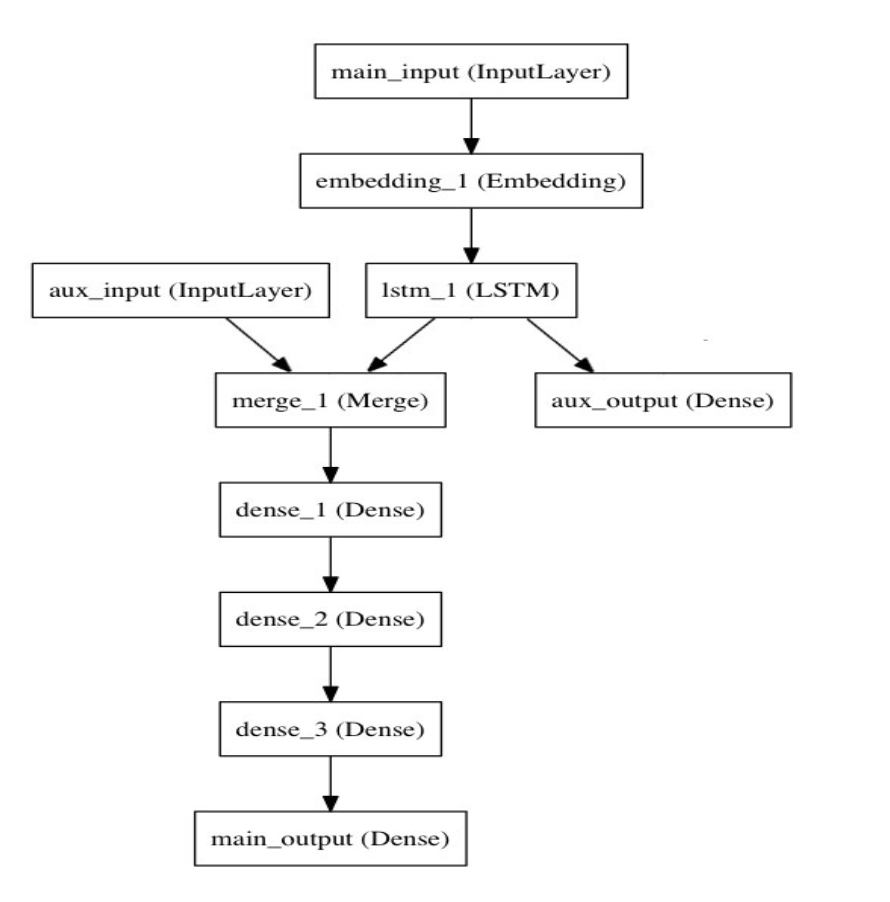
Let's implement it with the functional API.

The main input will receive the headline, as a sequence of integers (each integer encodes a word). The integers will be between 1 and 10,000 (a vocabulary of 10,000 words) and the sequences will be 100 words long.

In [ ]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
import numpy as

# Set a random seed for reproducibility
np.random.seed(0)

# Headline input: meant to receive sequences of 100 integers, between 1 and 10000.
# Note that we can name any layer by passing it a "name" argument
main_input = Input(shape=(100, ), dtype='int32', name='main_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors
x = Embedding(output_dim=512, input_dim=10000, input_length=100)(main_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(32, x)

Here we insert the auxiliary loss, allowing the LSTM and Embedding layer to be trained smoothly even though the main loss will be much higher in the model.

In [ ]:
auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(lstm_out)

At this point, we feed into the model out auxiliary input data by concatenating it with the LSTM output:

In [ ]:
auxiliary_input = Input(shape=(5, ), name='aux_input')
x = keras.layers.concatenate([lstm_out, auxiliary_input])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(1, activation='sigmoid', name='main_output')(x)

This defines a model with two inputs and two outputs

In [ ]:
model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])

We compile the model and assign a weight of 0.2 to the auxiliary loss. To specify different loss_weight or loss for each different output, you can use a list or a dictionary. Here we pass a single loss of loss augment, so the same loss will be used on all outputs.

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              loss_weights=[1., 0.2])

We can train the model by passing it lists of input arrays and target arrays

In [ ]:
headline_data = np.round(np.abs(np.random.rand(12, 100)*100))
additional_data = np.random.randn(12, 5)
headline_labels = np.random.randn(12, 1)
additional_labels = np.đanom.randn(12, 1)
model.fit([headline_data, additional_data], [headline_labels, additional_labels],
          epochs=50, batch_size=32)

Since our inputs and outputs are named (we passed them a "name" argument), we could also have compiled the model via:

In [ ]:
model.compile(optimizer='rmsprop',
              loss={'main_output': 'binary_crossentropy',
                    'aux_output': 'binary_crossentropy'},
              loss_weights={'main_output': 1.,
                            'aux_output': 0.2})

# Trained
model.fit({'main_input': headline_data, 'aux_input': additional_data},
          {'main_ouput': headline_labels, 'aux_output': additional_labels},
          epochs=50, batch_size=32)

To use the model for inferencing

In [ ]:
model.predict({'main_input': headline_data,
               'aux_input': additional_data})

Or alternatively

In [ ]:
pred = model.predict([headline_data, additional_data])

# **Shared layers**
Another good use for the functional API are models that use shared layers. Let's take a look at shared layers.

Let's consider a dataset of tweets. We want to build a model that can tell whether two tweets are from the same person or not (this can allow us to compare users by the similarity of their tweets for instance),

One way to achieve this is to build a model that encodes two tweets into two vectors, concatenates the vectors and then adds a logistic regression, this outputs a probability that the two tweets share the same author. The model would then be trained on positive tweet pairs and negative tweet pairs.

Because the problem is symetric, the mechanism that encodes the first tweet should be reused (weights and all) to encode the second tweet. Here we use a shared LSTM layer to encode the tweets.

Let's build this with the functional API. We will take as input for a tweet a binary matrix of shape (280, 256), a sequence of 280 vectors of size 256, where each dimension in the 256-dimensional vector encodes the presence/absence of a character (out of an alphabet of 256 frequent characters)

In [2]:
import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model

tweet_a = Input(shape=(280, 256))
tweet_b = Input(shape=(289, 256))

To share a layer across different inputs, simply instantiate the layer once, then call it on as many inputs as you want:

In [ ]:
# This layer can take as input a matrix and will return a vector of size 64
share_lstm = LSTM(64)
# When we reuse the same layer instance multiple times, the weights of the layer are also being reused
encoded_a = share_lstm(tweet_a)
encoded_b = share_lstm(tweet_b)

# We can then concatenate the two vectors
merged_vector = keras.layers.concatenate([encoded_a, encoded_b], axis=-1)

# And add a logistic regression on top
predictions = Dense(1, activation='sigmoid')(merged_vector)

# We define a trainable model linking the tweet inputs to the predictions
model = Model(inputs=[tweet_a, tweeet_b], outputs=predictions)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuaracy'])

model.fit([data_a, data_b], labels, epochs=10)

# **The concept of layer "node"**

Whenever you are calling a layer on some input, you are creating a new tensor(the output of the layer), and you are adding a "node" to the layer, linking the input tensor to the output tensor. When you are calling the same layer multiple times, that layer owns multiple nodes indexed as 0, 1, 2, ...

In previous versions of Keras, you could obtain the output tensor of a layer instance via layer.get_output(), or its output shape via layer.output_shape. You still can (except get_output() has been replaced by the property output). But what if a layer is connected to multiple inputs?

As long as a layer is only connected to one input, there is no confusion, and .output will return the one output of the layer

In [ ]:
a = Input(shape=(280, 256))
lstm = LSTM(32)
encoded_a = lstm(a)

assert lstm.output == encoded_a

Not so if the layer has multiple inputs

In [3]:
a = Input(shape=(280, 256))
b = Input(shape=(280, 256))

lstm = LSTM(32)
encoded_a = lstm(a)
encoded_b = lstm(b)

lstm.output

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'lstm')>

In [1]:
assert lstm.get_output_at(0) == encoded_a
assert lstm.get_output_at(1) == encoded_b

Them same is true for the properties input_shape and output_shape: as long as the layer has only one node, or as long as all nodes have the same input//output shape, then the notion of "layer output/input shape" is well defined, and that one shape will be returned by layer.output_shape/layer.input_shape. But if, for instance, you apply the same Conv2D layer to an input of shape (32, 32, 3), and then to an input of shape (64, 64, 3), the layer will have multiple input/output shapes, and you will have to fetch them by specifying the index of the node they belong to

In [ ]:
a = Input(shape=(32, 32, 3))
b = Input(shape=(64, 64, 3))

conv = Conv2D(16, (3, 3), padding='same')
conved_a = conv(a)

# Only one input so far, the following will work
assert conv.input_shape == (None, 32, 32, 3)

conved_b = conv(b)
# Now the '.input_shape' property wouldn't work, but this does:
assert conv.get_input_shape_at(0) == (None, 32, 32, 3)
assert conv.get_input_shape_at(1) == (None, 64, 64, 3)

# **More examples**

## **Inception module**

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Input
import keras
input_img = Input(shape=(256, 256, 3))

tower_1 = Conv2D(64, (1, 1), padding='same', activation='relu')(input_img)
tower_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(64, (1, 1), padding='same', activation='relu')(input_img)
tower_2 = Conv2D(64, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_img)
tower_3 = Conv2D(64, (1, 1), padding='same', activatiion='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

## **Residual connection on a convolution layer**
For more information about residual network, see Deep Residual Learning for Image Recognition

In [ ]:
# input tensor for a 3-channel 256x256 image
x = Input(shape=(256, 256, 3))
# 3x3 conv with 3 output channels (same as input channels)
y = Conv2D(3, (3, 3), padding='same')(x)
# This return x+y
z = keras.layers.add([x, y])

## **Shared vision model**
This model reuses the same image-processing module on two inputs, to classify whether two MNIST digits are the same digit or different digits.

In [ ]:
from keras.layers import Dense, Flatten
from keras.models import Model

# First, define the vision modules
digit_input = Input(shape=(27, 27, 1))
x = Conv2D(64, (3, 3))(digit_input)
x = Conv2D(64, (3, 3))(x)
x = MaxPooling2D((2, 2))(x)
out = Flatten()(x)

vision_model = Model(digit_input, out)

# Then define the tell-digits-apart model
digit_a = Input(shape=(27, 27, 1))
digit_b = Input(shape=(27, 27, 1))

# The vision model will be shared, weights and all
out_a = vision_model(digit_a)
out_b = vision_model(digit_b)

concatenated = keras.layers.concatenate([out_a, out_b])
out = Dense(1, activation='sigmoid')(concatenated)

classiffication_model = Model([digit_a, digit_b], out)

## **Visual question answering model**
This model can select the correct one-word answer when asked a natural-language question about a picture.

It works by encoding the question into a vector, encoding the image into a vector, concatenating the two, and training on top a logistic regression over some vocabulary of potential answers

In [ ]:
from keras.layers import LSTM, Embedding
from keras.models import Sequential

# First, let's define a vision model using a Sequential model.
# This model will encode an image into a vector
vision_model = Sequential()
vision_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
vision_model.add(Conv2D(64, (3, 3), activation='relu'))
vision_model.add(MaxPooling((2, 2)))

vision_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vision_model.add(Conv2D(128, (3, 3), actiation='relu'))
vision_model.add(MaxPooling((2, 2)))

vision_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vision_model.add(Conv2D(256, (3, 3), activation='relu'))
vision_model.add(Conv2D(256, (3, 3), activation='relu'))
vision_model.add(Flatten())

# Now let's get a tensor with the output of out vision model
image_input = Input(shape=(224, 224, 3))
encoded_image = vision_model(image_input)

# Next, let's define a language model to encode the question into a vector
# Each question will be at most 100 words long,
# and we will index words as integers from 1 to 9999
question_input = Input(shape=(100, ), dtype='int32')
embedded_question = Embedding(input_dim=10000, output_dim=256, input_length=100)(question_input)
encoded_question = LSTM(256)(embedded_question)

# Let's concatenate the question vector and the image vector
merged = keras.layers.concatenate([encoded_question, encoded_image])

# And let's train a logistic regression over 1000 words on top
output = Dense(1000, activation='softmax')(merged)

# This is our final model
vqa_model = Model(inputs=[image_input, question_input], outputs=output)

# The next stage would be training this model on actual data